# Vacation Planning - Assignment for Capstone Project

### Purpose:
I am planning to go to Italy for a few weeks and I thought that with so many places to see I should prioritize which landmarks etc. I see in each city based on the number of days I plan to spend there. 
I want to know which venues to go to on each day.

### Methodology:
1. Define the city for which to get the venues. Practically, I will run this notebook for each city I plan to go to based on the number of days I will spend there
2. Define the kinds of venues I want to go to such as museums, landmarks etc.
3. Find the ratings of all those venues (NOTE: ratings are different than trending)
4. Set a rating threshold to weed out venues that are lowly rated and not worth going to
5. Define the number of days spent in that city
6. Days = number of clusters in the K-Means algorithm
7. Use K-means to label the venues - each label corresponds to a day.
8. Clustering of K-means is based on the longitudes and langitudes; venues that are closer nearby will be clustered together
9. I have a basic itinerary planned which I can refine further (not in this notebook)

#### Importing necessary libraries

In [2]:
! pip install geopy

     |████████████████████████████████| 102kB 7.8MB/s ta 0:00:011


In [3]:
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [4]:
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

#### Setting up the Foursquare credentials. Hidden in this notebook

In [6]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Setting up the City where I am spending some days of my vacation

In [7]:
vacation_spot = 'Florence, Italy'
geolocator = Nominatim(user_agent="italy_explorer")
location = geolocator.geocode(vacation_spot)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(vacation_spot, latitude, longitude))

The geograpical coordinate of Florence, Italy are 43.7698712, 11.2555757.


#### Let's just have a basic view of where I would be staying :D

In [8]:
map_vacation_spot = folium.Map(location=[latitude, longitude], zoom_start=12)    
map_vacation_spot

#### Setting up the request URL.
I am using a **search** call, and passing the **categories** of venues I would like to see. For me those are:
1. Museums --> 4bf58dd8d48988d181941735
2. Landmarks --> 4bf58dd8d48988d12d941735

These category ids can be found at: https://developer.foursquare.com/docs/resources/categories

In [9]:
# type your answer here
LIMIT = 100
RADIUS = 1000
#categories I am interested in are: Museums, Landmarks -- these are the things I am interested in seeing
CATEGORIES = '4bf58dd8d48988d181941735,4bf58dd8d48988d12d941735'

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, RADIUS, LIMIT,CATEGORIES)
url

'https://api.foursquare.com/v2/venues/search?client_id=CUVPE1DHFIWFIPWM40Q3OWNJ3QDNKAJTDOHIMQ1ADV3RKAOV&client_secret=QDX2QO0TP5UCIYVDNSIVIQRA14ODVS53O0ADXLIBQS32JBUD&ll=43.7698712,11.2555757&v=20180605&radius=1000&limit=100&categoryId=4bf58dd8d48988d181941735,4bf58dd8d48988d12d941735&intent=browse'

#### Getting the response from the request
Once the response is received we:
1. json normalize it
2. preprocess the dataframe to find the categories of the venue
3. only get columns we are interested in: venue_id, name, latitude and longitude

In [10]:
results = requests.get(url).json()
venues = results['response']['venues']

In [11]:
raw_vacation_df = json_normalize(venues)
raw_vacation_df.shape

(31, 19)

#### There are **31** venues of the categories that I specified in Florence.

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
raw_vacation_df['categories'] = raw_vacation_df.apply(get_category_type, axis=1)
raw_vacation_df.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.neighborhood,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,venuePage.id
0,4bd00cdb046076b00a576f71,Cattedrale di Santa Maria del Fiore,Church,v-1580215046,False,Piazza del Duomo,43.773108,11.255879,"[{'label': 'display', 'lat': 43.77310810591076...",361,50122,IT,"Centro Storico, Firenze, Toscana",Firenze,Toscana,Italia,"[Piazza del Duomo, 50122 Firenze Toscana, Italia]",NaN,NaN
1,51191cdfb0ed67c8fff5610b,Galleria degli Uffizi,Art Museum,v-1580215046,False,"Via della Ninna, 5",43.768721,11.255554,NaN,128,50122,IT,NaN,Firenze,Toscana,Italia,"[Via della Ninna, 5 (Piazza della Signoria), 5...",Piazza della Signoria,NaN
2,4bcd9011fb84c9b64524223e,Galleria dell'Accademia,Art Museum,v-1580215046,False,Via Ricasoli 58,43.776907,11.258654,"[{'label': 'display', 'lat': 43.77690738502633...",821,50122,IT,NaN,Firenze,Toscana,Italia,"[Via Ricasoli 58, 50122 Firenze Toscana, Italia]",NaN,NaN
3,4bc8c9d7af07a593d4aa812d,Palazzo Pitti,Art Museum,v-1580215046,False,Piazza dei Pitti,43.765658,11.249919,"[{'label': 'display', 'lat': 43.76565831258718...",653,50125,IT,Oltrarno,Firenze,Toscana,Italia,"[Piazza dei Pitti (Sdrucciolo dei Pitti), 5012...",Sdrucciolo dei Pitti,NaN
4,4bd432ff41b9ef3b1a9001e6,David di Michelangelo,Monument / Landmark,v-1580215046,False,Galleria dell'Accademia,43.776835,11.258575,"[{'label': 'display', 'lat': 43.77683493139089...",811,50122,IT,San Marco,Firenze,Toscana,Italia,"[Galleria dell'Accademia, 50122 Firenze Toscan...",NaN,NaN


In [14]:
raw_vacation_df['categories'].value_counts()

Art Museum             9
Museum                 6
Monument / Landmark    6
History Museum         3
Science Museum         1
Italian Restaurant     1
Art Gallery            1
Fountain               1
Scenic Lookout         1
Church                 1
Sculpture Garden       1
Name: categories, dtype: int64

I see there are mostly art museums. At this stage I could decide to refine the categories I am interested in and redo the search. \
But I will stick with this and move ahead with my analysis \

Now I will do some cleaning of the dataframe and get only columns I need + remove the location. from some attribute names

In [15]:
vacation_df = raw_vacation_df[['id','name','categories','location.lat','location.lng']]
vacation_df.columns = [column.split('.')[-1] for column in vacation_df.columns]
vacation_df.head()

,id,name,categories,lat,lng
0,4bd00cdb046076b00a576f71,Cattedrale di Santa Maria del Fiore,Church,43.773108,11.255879
1,51191cdfb0ed67c8fff5610b,Galleria degli Uffizi,Art Museum,43.768721,11.255554
2,4bcd9011fb84c9b64524223e,Galleria dell'Accademia,Art Museum,43.776907,11.258654
3,4bc8c9d7af07a593d4aa812d,Palazzo Pitti,Art Museum,43.765658,11.249919
4,4bd432ff41b9ef3b1a9001e6,David di Michelangelo,Monument / Landmark,43.776835,11.258575


#### Now we want to get the ratings of each venue.
This requires a **premium** call - the result of which contains the rating of that venue. \
**Note:** not all venues have ratings. I remove those venues from my dataframe

In [62]:
venue_id = vacation_df.iloc[0,0]
venue_id
ratings = []

#iterate over the dataframe and send a venue details call for each venue, and append their ratings to the ratings list
for index, row in vacation_df.iterrows():
    venue_id = row['id']
    details_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    details_response  = requests.get(details_url).json()
    try:
        venue_rating = details_response['response']['venue']['rating']
    except Exception as e:
        venue_rating = np.nan #for venues that dont have rating, I temporarily add a NaN value.
    ratings.append(venue_rating)

#### Since there is a quote on premium calls, I added these save to csv and read from csv functions

This allows me to save the csv file so that I can test the code using that file if my quota exceeds

In [63]:
if ratings.count(np.nan) == len(ratings):
    vacation_df = pd.read_csv('Vacations.csv',index_col=0)
    vacation_df.dropna(inplace=True)
    print("Reading data from CSV as quota for premium calls has exceeded")
else:
    vacation_df['ratings'] = ratings
    vacation_df.dropna(inplace=True)
    print("Reading data from the premium calls made right now as I have quota")

vacation_df

Reading data from CSV as quota for premium calls has exceeded


,id,name,categories,lat,lng,ratings
0,4bd00cdb046076b00a576f71,Cattedrale di Santa Maria del Fiore,Church,43.773108,11.255879,9.5
1,51191cdfb0ed67c8fff5610b,Galleria degli Uffizi,Art Museum,43.768721,11.255554,9.1
2,4bcd9011fb84c9b64524223e,Galleria dell'Accademia,Art Museum,43.776907,11.258654,8.8
3,4bc8c9d7af07a593d4aa812d,Palazzo Pitti,Art Museum,43.765658,11.249919,8.9
4,4bd432ff41b9ef3b1a9001e6,David di Michelangelo,Monument / Landmark,43.776835,11.258575,9.3
5,4bc97c2dfb84c9b65a301b3e,Palazzo Medici-Riccardi,Museum,43.775182,11.255335,9.0
6,4b49cd73f964a520d87326e3,Campanile di Giotto,Monument / Landmark,43.772837,11.255692,9.0
7,5a759d5f8e886a73e9d0f995,Gucci Garden,Museum,43.769851,11.256550,8.2
8,4c64255a79d1e21efe4bda15,Palazzo Strozzi,Art Museum,43.771379,11.251829,9.2
9,4bd00aa8b221c9b6c80cd3d0,Museo dell'Opera del Duomo,Museum,43.772988,11.257492,8.9


In [18]:
#vacation_df.to_csv('Vacations.csv')

In [64]:
vacation_df.shape

(29, 6)

#### After removing places that had no ratings, I have 29 venues in Florence that match my categories

#### Next step is to set a threshold for ratings. I only want venues that have rating of greater than 8

In [65]:
ratings_threshold = 8

vacation_df = vacation_df.loc[vacation_df['ratings'] >= 8]
vacation_df

,id,name,categories,lat,lng,ratings
0,4bd00cdb046076b00a576f71,Cattedrale di Santa Maria del Fiore,Church,43.773108,11.255879,9.5
1,51191cdfb0ed67c8fff5610b,Galleria degli Uffizi,Art Museum,43.768721,11.255554,9.1
2,4bcd9011fb84c9b64524223e,Galleria dell'Accademia,Art Museum,43.776907,11.258654,8.8
3,4bc8c9d7af07a593d4aa812d,Palazzo Pitti,Art Museum,43.765658,11.249919,8.9
4,4bd432ff41b9ef3b1a9001e6,David di Michelangelo,Monument / Landmark,43.776835,11.258575,9.3
5,4bc97c2dfb84c9b65a301b3e,Palazzo Medici-Riccardi,Museum,43.775182,11.255335,9.0
6,4b49cd73f964a520d87326e3,Campanile di Giotto,Monument / Landmark,43.772837,11.255692,9.0
7,5a759d5f8e886a73e9d0f995,Gucci Garden,Museum,43.769851,11.256550,8.2
8,4c64255a79d1e21efe4bda15,Palazzo Strozzi,Art Museum,43.771379,11.251829,9.2
9,4bd00aa8b221c9b6c80cd3d0,Museo dell'Opera del Duomo,Museum,43.772988,11.257492,8.9


In [66]:
vacation_df.shape

(23, 6)

#### After setting rating threshold, I have 23 venues of interest in Florence. Let's visualize them

In [67]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Rome

# add the landmarks and museums as blue circle markers
for lat, lng, category, name in zip(vacation_df['lat'], vacation_df['lng'], vacation_df['categories'], vacation_df['name']):
    label = folium.Popup(str(name) + ' | ' + str(category), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map.save('Venues_Without_Labels.html')
venues_map

#### Also, let us see how these coordinates look on a scatter plot. This gives a rough idea of the kind of clusters that could be formed

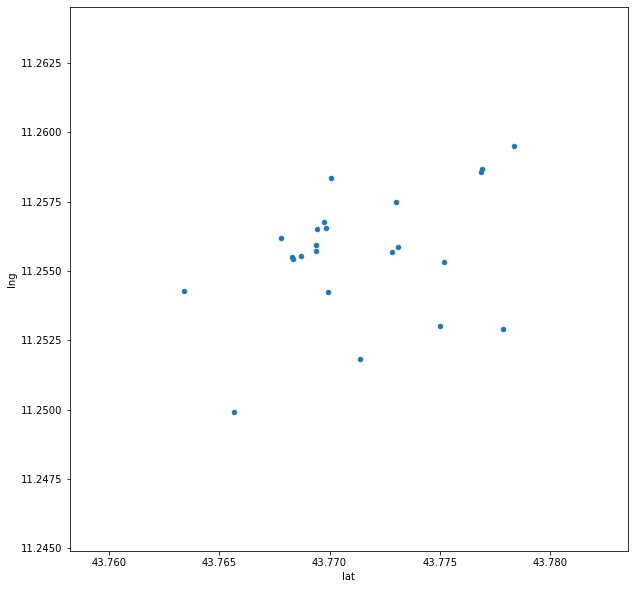

In [68]:
import matplotlib.pyplot as plt
vacation_df.plot(kind='scatter', x='lat', y='lng', figsize=(10,10))
plt.savefig("Venues_Scatter.jpg")

#### Proceeding to clustering. 

1. Clustering will be based on latitude and longitude of the venues
2. Number of clusters = number of days I want to spend in florence

In [69]:
#Clustering

#removed the text columns - clustering only based on lat, lng
vacation_clustering_df = vacation_df[['lat', 'lng']]
vacation_clustering_df.head()

,lat,lng
0,43.773108,11.255879
1,43.768721,11.255554
2,43.776907,11.258654
3,43.765658,11.249919
4,43.776835,11.258575


In [70]:
#some preprocessing to get data ready for clustering
from sklearn.preprocessing import StandardScaler

X = vacation_clustering_df.values[:,:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.46307167,  0.10780915],
       [-0.67486705, -0.03961156],
       [ 1.44849289,  1.36327756],
       [-1.46918553, -2.58905829],
       [ 1.42970055,  1.32748212],
       [ 1.00093614, -0.13857124],
       [ 0.39274328,  0.02285771],
       [-0.38171641,  0.41138685],
       [ 0.01462045, -1.72489482],
       [ 0.43190178,  0.83743166],
       [-0.91395659,  0.25356868],
       [ 0.95713317, -1.19050048],
       [-0.36750845, -0.635525  ],
       [-0.77252197, -0.09050977],
       [-0.32794477,  1.22108426],
       [-0.4929543 ,  0.38935545],
       [-0.77899326, -0.06974163],
       [-0.40473356,  0.50051673],
       [ 1.82030286,  1.74503475],
       [-0.5087109 ,  0.13601263],
       [-2.05812087, -0.62564653],
       [-0.50326233,  0.03301724],
       [ 1.69557319, -1.24477548]])

In [71]:
#here I specify how long I want to stay
number_of_days_vacation = 4

k_means = KMeans(init="k-means++", n_clusters=number_of_days_vacation, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[2 2 3 1 3 0 2 2 0 2 2 0 2 2 2 2 2 2 3 2 1 2 0]


In [72]:
#adding the cluster labels to the original dataframe
vacation_df.loc[:,'labels'] = labels
vacation_df.head()

,id,name,categories,lat,lng,ratings,labels
0,4bd00cdb046076b00a576f71,Cattedrale di Santa Maria del Fiore,Church,43.773108,11.255879,9.5,2
1,51191cdfb0ed67c8fff5610b,Galleria degli Uffizi,Art Museum,43.768721,11.255554,9.1,2
2,4bcd9011fb84c9b64524223e,Galleria dell'Accademia,Art Museum,43.776907,11.258654,8.8,3
3,4bc8c9d7af07a593d4aa812d,Palazzo Pitti,Art Museum,43.765658,11.249919,8.9,1
4,4bd432ff41b9ef3b1a9001e6,David di Michelangelo,Monument / Landmark,43.776835,11.258575,9.3,3


#### Once the clustering has been done and labels assigned, lets visualize my itinerary

In [73]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(number_of_days_vacation)
#ys = [i + x + (i*x)**2 for i in range(number_of_days_vacation)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(vacation_df['lat'], vacation_df['lng'], vacation_df['name'], vacation_df['labels']):
    label = folium.Popup(str(name) + ' | Day= ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('Venue Clusters.html')
map_clusters

#### Even though K-means has provided clustering, I am not really sure about the efficacy of it. I want to try GaussianMixture which performs better than k-means

Read more on: https://towardsdatascience.com/gaussian-mixture-models-d13a5e915c8e

In [74]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=number_of_days_vacation, n_init=12)

In [75]:
gm_labels = gm.fit_predict(cluster_dataset)
gm_labels

array([3, 1, 0, 2, 0, 3, 3, 1, 2, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 1, 1, 1,
       3])

Let's create a **copy** of the vacation dataframe that had labels. We will add the labels proposed by GaussianMixture

In [76]:
gm_df = vacation_df.copy()
gm_df.head()

,id,name,categories,lat,lng,ratings,labels
0,4bd00cdb046076b00a576f71,Cattedrale di Santa Maria del Fiore,Church,43.773108,11.255879,9.5,2
1,51191cdfb0ed67c8fff5610b,Galleria degli Uffizi,Art Museum,43.768721,11.255554,9.1,2
2,4bcd9011fb84c9b64524223e,Galleria dell'Accademia,Art Museum,43.776907,11.258654,8.8,3
3,4bc8c9d7af07a593d4aa812d,Palazzo Pitti,Art Museum,43.765658,11.249919,8.9,1
4,4bd432ff41b9ef3b1a9001e6,David di Michelangelo,Monument / Landmark,43.776835,11.258575,9.3,3


In [77]:
gm_df['gm_labels'] = gm_labels

In [78]:
gm_df

,id,name,categories,lat,lng,ratings,labels,gm_labels
0,4bd00cdb046076b00a576f71,Cattedrale di Santa Maria del Fiore,Church,43.773108,11.255879,9.5,2,3
1,51191cdfb0ed67c8fff5610b,Galleria degli Uffizi,Art Museum,43.768721,11.255554,9.1,2,1
2,4bcd9011fb84c9b64524223e,Galleria dell'Accademia,Art Museum,43.776907,11.258654,8.8,3,0
3,4bc8c9d7af07a593d4aa812d,Palazzo Pitti,Art Museum,43.765658,11.249919,8.9,1,2
4,4bd432ff41b9ef3b1a9001e6,David di Michelangelo,Monument / Landmark,43.776835,11.258575,9.3,3,0
5,4bc97c2dfb84c9b65a301b3e,Palazzo Medici-Riccardi,Museum,43.775182,11.255335,9.0,0,3
6,4b49cd73f964a520d87326e3,Campanile di Giotto,Monument / Landmark,43.772837,11.255692,9.0,2,3
7,5a759d5f8e886a73e9d0f995,Gucci Garden,Museum,43.769851,11.256550,8.2,2,1
8,4c64255a79d1e21efe4bda15,Palazzo Strozzi,Art Museum,43.771379,11.251829,9.2,0,2
9,4bd00aa8b221c9b6c80cd3d0,Museo dell'Opera del Duomo,Museum,43.772988,11.257492,8.9,2,3


In [79]:
gm_df['labels'].value_counts()

2    14
0     4
3     3
1     2
Name: labels, dtype: int64

In [80]:
gm_df['gm_labels'].value_counts()

1    11
3     7
0     3
2     2
Name: gm_labels, dtype: int64

#### The above value_counts show that the labels provided by the GaussianMatrix algorithm are more 'manageable' from a vacation perspective

#### Let's visualize the map based on GaussianMatrix

In [81]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(number_of_days_vacation)
#ys = [i + x + (i*x)**2 for i in range(number_of_days_vacation)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(gm_df['lat'], gm_df['lng'], gm_df['name'], gm_df['gm_labels']):
    label = folium.Popup(str(name) + ' | Day= ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('Venue Clusters Gaussian.html')
map_clusters

### I opted for Gaussian Matrix Algo for the labelling 

Below is the complete set of data or itinerary that could potentially be followed
I am sorting the data by labels (or days) and then further sorting by the ratings so that I visit the venues with the highest ratings on a particular day

In [ ]:
vacation_df['labels'] = gm_df['gm_labels']

vacation_df.sort_values(by=['labels','ratings'], ascending=[True, False], inplace=True)
vacation_df.reset_index(drop=True, inplace=True)

vacation_df.to_csv('Itinerary.csv')
vacation_df.to_html()
vacation_df

#### Areas of Improvement:
1. See practically how long does it take to visit a place. It could be different for different venues. One can add a column of time needed to see and then maybe set thresholds per day, and somehow incorporate that into the clustering
2. Apart from ratings, one can have additional columns of their own preference of categories or venues. One could then calculate the aggregrate scores of clusters
4. Budget would be a real consideration. Maybe estimated cost per venue can be added to the dataframe and decisions made on the combination of venues that would not break the balance but provide the best experience